In [10]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [11]:
import numpy as np 
import  matplotlib.pyplot as plt 
%matplotlib notebook 
# last line enables interactive plotting in notebooks 

In [63]:
#!python

# -------- these are not just comments. These are compiler directives. 
# They make code run a bit faster. You should take them away for debug/development
# (if you use wraparound=False you can't use negative number for indexing arrays from the end)
#
#cython: boundscheck=False
#cython: wraparound=False
#cython: initializedcheck=True

import numpy as np
import cython  




cohesinAmount = 15
rnapAmount = 10
baseNumber = 1010
geneNumber = 46
maxLength = 10
minLength = 4
speedRnap = .75
speedCohesin = .5
stepNumber = 5000

sisterOne = np.empty(cohesinAmount + rnapAmount, dtype=int)
sisterTwo = np.empty(cohesinAmount + rnapAmount, dtype=int)


def isOccupied(array, place):
    """
    Checks if a place on a chromatid is occupied by a protien
    
    Parameters
    ----------
    array : one of the two chromatids
    place : location on a chromatid
    
    Returns:
    --------
    true if the place is occupied and false if it is not occupied
    """
    return (array == place).any()

def extendedOccupied(array, place, length):
    """
    Checks if a segment on a chromatid is occupied by any protien
    
    Parameters
    ----------
    array : one of the two chromatids
    place : location on a chromatid
        Gives the starting point of the segment
    length: integer
        Gives the length of the segment
    
    Returns:
    --------
    true if the segment has any protiens and false if it is empty
    """
    return ((array >= place) * (array < (place + length))).any()

def checkProtien(array, place):
    """
    Finds the location of a protien on a chromatid
    
    Parameters
    ----------
    array : one of the two chromatids
    place : location on a chromatid
    
    Returns:
    --------
    index on the chromatid array of the protien which is in the set location
    """
    return np.where(array == place)[0]

def cohesinPair(chromatid1, chromatid2, cohesin):
    return (chromatid1[rnapAmount + cohesin], chromatid2[rnapAmount + cohesin])

def findCohesinPairList(chromatid1, chromatid2):
    cohesinPairList = np.empty(cohesinAmount, dtype=list)
    for cohesin in range(0, cohesinAmount):
        cohesinPairList[cohesin] = cohesinPair(chromatid1, chromatid2, cohesin)
    return cohesinPairList

def pullIndex(array, index):
    arrayIndex = np.empty(len(array), dtype=int)
    point = 0
    while point < len(array):
        arrayIndex[point] = array[point][index]
        point = point + 1
    return arrayIndex

def generateGeneLengths():
    """
    Generates the legnths of all the genes

    Returns:
    --------
    an array of lengths for all the genes
    """
    geneLengths = np.empty(geneNumber, dtype=int)
    for gene in range(0, geneNumber):
        geneLengths[gene] = np.random.randint(minLength,maxLength)
    return geneLengths

def generateShadowGenes(geneLengths):
    """
    Generates the lengths of the empty spaces between genes
    
    Paramaters:
    ----------
    geneLengths : an array given by generateGeneLengths()
        This is needed to know how long the sum of the shadow lengths is
    
    Returns:
    --------
    array of 'shadow genes'
    """
    finalSum = baseNumber - sum(geneLengths)
    shadowGenes = np.empty(geneNumber + 1, dtype=int)
    pseudoShadow = np.empty(geneNumber + 1, dtype=float)
    for shadowIndex in range(0, geneNumber + 1):
        pseudoShadow[shadowIndex] = np.random.random()
    pseudoLength = sum(pseudoShadow)
    for shadow in range(0, geneNumber + 1):
        pseudoShadow[shadow] = pseudoShadow[shadow]/pseudoLength
        shadowGenes[shadow] = round(finalSum*pseudoShadow[shadow], 0)
    return shadowGenes

def generateDirection():
    """
    Generates an array of gene directions

    Returns:
    --------
    an array in which -1 means the gene is going backwards and 1 means it is going formwards
    """
    geneDirection = np.empty(geneNumber, dtype=int)
    for gene in range(0, geneNumber):
        geneFlip = np.random.random()
        if geneFlip < 0.5:
            geneDirection[gene] = -1
        else:
            geneDirection[gene] = 1
    return geneDirection
    
def generateGenes(geneLengths, shadowGenes):
    """
    Generates genes without direction
    
    Parameters
    ----------
    geneLengths : The array given by generateGeneLenths()
    shadowGenes : The array given by generateShadowGenes()
    
    Returns:
    --------
    an array which holds the starting points of each gene assuming no direction
    """
    geneList = np.empty(geneNumber, dtype=int)
    geneList[0] = shadowGenes[0]
    geneStart = shadowGenes[0]
    for gene in range(0, geneNumber-1):
        geneStart = geneStart+geneLengths[gene]+shadowGenes[gene+1]
        geneList[gene+1] = geneStart
    return geneList

def flipGenes(geneList, geneDirection, geneLength):
    """
    Flips the genes which have a negative direction
    
    Parameters
    ----------
    geneList : The array generated by generateGenes()
    geneDirection : The array generated by generateGeneDirection()
    geneLength : The array given by generateGeneLenths()
      
    Returns:
    --------
    an array which holds the starting points of each gene
    """
    for gene in range(0, geneNumber):
        if geneDirection[gene] == -1:
            geneList[gene] = geneList[gene] + geneLength[gene]
    return geneList

def generateFullDNA(geneList, geneDirection, geneLength):
    """
    Generates the full DNA information
    
    Parameters
    ----------
    geneList : The array given by generateGenes()
    geneDirection : The array generated by generateGeneDirection()
    geneLengths : The array given by generateGeneLenths()
    
    
    Returns:
    --------
    an array in which for every base which is part of a gene it has 1 if the gene is going forward and -1 if it is going backwards
    """
    fullDNA = np.empty(baseNumber, dtype = int)
    for base in range(0, baseNumber):
        fullDNA[base] = 0
    for gene in range(0, geneNumber):
        if geneDirection[gene] == 1:
            for base in range(0, geneLength[gene]):
                fullDNA[geneList[gene] + base] = 1
        else:
            for base in range(0, geneLength[gene]):
                fullDNA[geneList[gene] - base] = -1
    return fullDNA

def generateCohesins(array):
    """
    Generates cohesin locations
    
    Parameters
    ----------
    array : a sister chromatid
    
    Returns:
    --------
    an array which contains the information about the lovations of cohesins on a chromatid
    """
    cohesin = 0
    while cohesin < cohesinAmount:
        place = np.random.randint(0, baseNumber)
        if not isOccupied(array, place):
            array[rnapAmount+cohesin] = place
            cohesin = cohesin + 1
    return array

def generateRnaps(array, geneList):
    """
    Generates RNAP locations
    
    Parameters
    ----------
    array : a sister chromatid
    geneList : the array generated by flipGenes()
    
    Returns:
    --------
    an array which contains the information about the lovations of RNAPs on a chromatid
    """
    rnap = 0
    while rnap < rnapAmount:
        gene = np.random.randint(0, geneNumber)
        if not isOccupied(array, geneList[gene]):
            array[rnap] = geneList[gene]
            rnap = rnap + 1
    return array
    
    




In [64]:
#geneLengths = generateGeneLengths()
#shadowGenes = generateShadowGenes(geneLengths)
#geneDirections = generateDirection()
#geneList = generateGenes(geneLengths, shadowGenes)
#geneList = flipGenes(geneList, geneDirections, geneLengths)
geneList = np.array([6,51,73,121,130,151,166,175,198,205,208,232,241,247,272,317,324,350,365,379,392,398,425,459,478,480,501,520,534,580,635,644,705,711,739,745,781,798,823,839,851,860,885,949,963,997])
geneLengths = np.array([41,18,27,19,5,18,8,14,6,3,2,20,5,7,25,18,7,17,8,4,6,13,5,29,6,12,11,5,6,48,5,29,20,9,17,4,29,5,18,12,2,15,21,25,22,8])
geneDirections = np.array([1,1,1,-1,-1,-1,-1,1,-1,-1,1,-1,-1,1,1,-1,1,-1,-1,1,-1,1,(-1),-1,-1,1,1,1,1,1,(-1),1,-1,1,-1,(1),-1,1,-1,-1,-1,1,1,-1,1,1])
#print("shadow gene lengths: " , shadowGenes)
print("gene lengths: " , geneLengths)
print("gene lengths: " , len(geneLengths))
print("gene directions: " , geneDirections)
print("gene directions: " , len(geneDirections))
print("gene list: " , geneList)
print("gene list: " , len(geneList))
fullDNA = generateFullDNA(geneList, geneDirections, geneLengths)

#print(fullDNA)




gene lengths:  [41 18 27 19  5 18  8 14  6  3  2 20  5  7 25 18  7 17  8  4  6 13  5 29
  6 12 11  5  6 48  5 29 20  9 17  4 29  5 18 12  2 15 21 25 22  8]
gene lengths:  46
gene directions:  [ 1  1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1  1 -1 -1  1 -1  1 -1 -1
 -1  1  1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1  1  1 -1  1  1]
gene directions:  46
gene list:  [  6  51  73 121 130 151 166 175 198 205 208 232 241 247 272 317 324 350
 365 379 392 398 425 459 478 480 501 520 534 580 635 644 705 711 739 745
 781 798 823 839 851 860 885 949 963 997]
gene list:  46


In [68]:

def stepRnap(array, fullDNA):
    """
    Moves all the RNAPs along there genes
    
    Parameters
    ----------
    array : a sister chromatid
    fullDNA : array generated by generateFullDNA()
    
    Returns:
    --------
    an array which contains the information about the locations of RNAPS on a chromatid after a step
    """
    movingRnap = 0
    speed = speedRnap
    arrayInitial = np.copy(array)
    while movingRnap < rnapAmount:
        if fullDNA[array[movingRnap]+1] == 0:
            gene = np.random.randint(0, geneNumber)
            if not isOccupied(array, geneList[gene]):
                array[movingRnap] = geneList[gene]
                movingRnap = movingRnap + 1
        else:
            movementCheck = np.random.random()
            if movementCheck < speed:
                if not isOccupied(array, array[movingRnap] + fullDNA[array[movingRnap]]):
                    array[movingRnap] = array[movingRnap] + fullDNA[array[movingRnap]]
                    movingRnap = movingRnap + 1
                else:
                    check = 0
                    while isOccupied(arrayInitial, arrayInitial[movingRnap] + fullDNA[array[movingRnap]]*(1+check)):
                        checkedIndex = arrayInitial[movingRnap] + fullDNA[arrayInitial[movingRnap]]*(1+check)
                        array[checkProtien(arrayInitial, checkedIndex)] = arrayInitial[movingRnap] + fullDNA[arrayInitial[movingRnap]]*(2+check)
                        check = check + 1
                        #print("push", checkedIndex)
                    array[movingRnap] = array[movingRnap] + fullDNA[array[movingRnap]]
                    movingRnap = movingRnap + 1
            else:
                movingRnap = movingRnap + 1
    return array
            
def stepCohesin(array):
    """
    Moves all the cohesinss along there genes
    
    Parameters
    ----------
    array : a sister chromatid
    fullDNA : array generated by generateFullDNA()
    
    Returns:
    --------
    an array which contains the information about the locations of cohesins on a chromatid after a step
    """
    movingCohesin = 0
    speed = speedCohesin
    while movingCohesin < cohesinAmount:
        movementCheck = np.random.random()
        if movementCheck > speed:
            movingCohesin = movingCohesin + 1
        elif movementCheck > speed/2:
            if array[rnapAmount + movingCohesin] < baseNumber:
                if not isOccupied(array, array[rnapAmount + movingCohesin] + 1):
                    array[rnapAmount + movingCohesin] = array[rnapAmount + movingCohesin] + 1
            movingCohesin = movingCohesin + 1
        else:
            if array[rnapAmount + movingCohesin] > 0:
                if not isOccupied(array, array[rnapAmount + movingCohesin] - 1):
                    array[rnapAmount + movingCohesin] = array[rnapAmount + movingCohesin] - 1
            movingCohesin = movingCohesin + 1
    return array

def fullStep(array, fullDNA):
    """
    Moves all the protiens along there genes
    
    Parameters
    ----------
    array : a sister chromatid
    fullDNA : array generated by generateFullDNA()
    
    Returns:
    --------
    an array which contains the information about the locations of protiens on a chromatid after a step
    """
    array = stepRnap(array, fullDNA)
    array = stepCohesin(array)
    return array




[  6  51  73 121 130 151 166 175 198 205 208 232 241 247 272 317 324 350
 365 379 392 398 425 459 478 480 501 520 534 580 635 644 705 711 739 745
 781 798 823 839 851 860 885 949 963 997]
[ 1  1  1 -1 -1 -1 -1  1 -1 -1  1 -1 -1  1  1 -1  1 -1 -1  1 -1  1 -1 -1
 -1  1  1  1  1  1 -1  1 -1  1 -1  1 -1  1 -1 -1 -1  1  1 -1  1  1]
sisterOne:  [398 166 459 644 745  51 365 425 121 705  49 641 368 348 565   2 227 495
 271 352 861 131 191 934 762]
sisterTwo:  [781 949  51 365 247 823 711 839 644 241  49 641 368 348 565   2 227 495
 271 352 861 131 191 934 762]


<IPython.core.display.Javascript object>


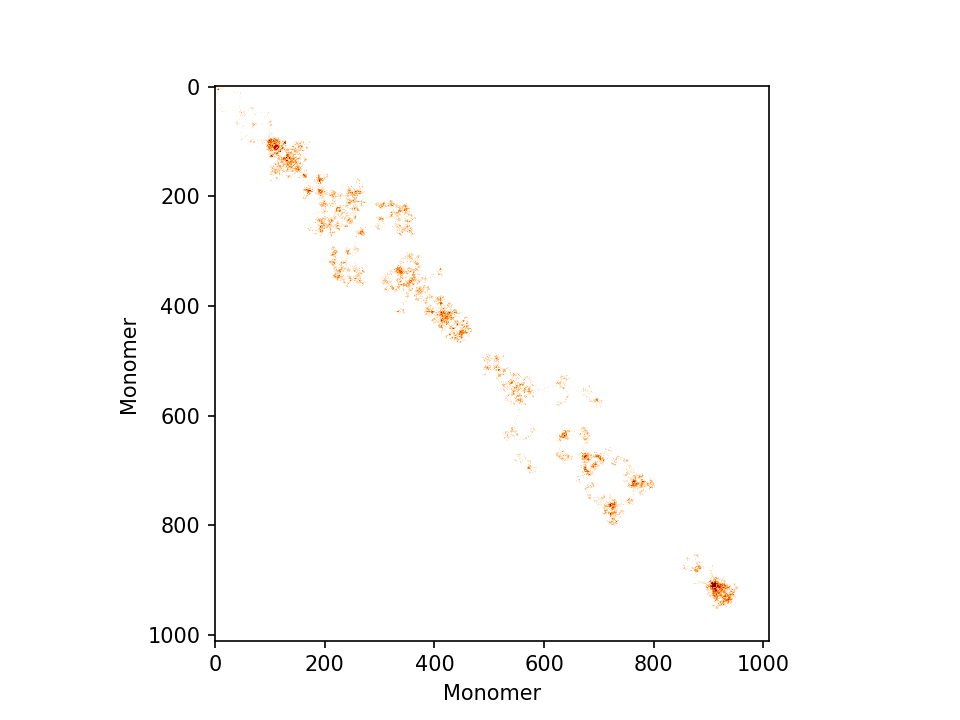

done


In [74]:
print(geneList)
print(geneDirections)
sisterOne = generateCohesins(sisterOne)
sisterTwo = np.copy(sisterOne)
sisterOne = generateRnaps(sisterOne, geneList)
sisterTwo = generateRnaps(sisterTwo, geneList)
# arrayFail = np.array([73, 120, 197, 249, 301, 250, 251, 252, 253, 196, 195, 72, 254, 255, 256])
print("sisterOne: " , sisterOne)
print("sisterTwo: " , sisterTwo)
cohesinHeatArray = np.zeros(shape=(baseNumber+1, baseNumber+1))

for itteration in range(0, stepNumber):
    sisterOne = fullStep(sisterOne, fullDNA)
    sisterTwo = fullStep(sisterTwo, fullDNA)  
    cohesinPairList = findCohesinPairList(sisterOne, sisterTwo)
    cohesinPairOne = pullIndex(cohesinPairList, 0)
    cohesinPairTwo = pullIndex(cohesinPairList, 1)
    cohesinHeatArray[cohesinPairOne, cohesinPairTwo] = cohesinHeatArray[cohesinPairOne, cohesinPairTwo] - 1
    cohesinHeatArray[cohesinPairTwo, cohesinPairOne] = cohesinHeatArray[cohesinPairTwo, cohesinPairOne] - 1
    #print(itteration, " sisterOne: " , sisterOne)
    #print(itteration, " sisterTwo: " , sisterTwo)
    #print(itteration)

plt.imshow(cohesinHeatArray, cmap='gist_heat')    
plt.xlabel("Monomer")
plt.ylabel("Monomer")
plt.show()
print("done")

In [ ]:
print(geneList)
print(geneDirections)
sisterOne = generateCohesins(sisterOne)
sisterTwo = np.copy(sisterOne)
sisterOne = generateRnaps(sisterOne, geneList)
sisterTwo = generateRnaps(sisterTwo, geneList)
# arrayFail = np.array([73, 120, 197, 249, 301, 250, 251, 252, 253, 196, 195, 72, 254, 255, 256])
print("sisterOne: " , sisterOne)
print("sisterTwo: " , sisterTwo)

for itteration in range(0, stepNumber):
    sisterOne = fullStep(sisterOne, fullDNA)
#    print(itteration, " sisterOne: " , sisterOne)
    sisterTwo = fullStep(sisterTwo, fullDNA)  
#    print(itteration, " sisterTwo: " , sisterTwo)
    cohesinPairList = findCohesinPairList(sisterOne, sisterTwo)
    cohesinPairOne = pullIndex(cohesinPairList, 0)
    cohesinPairTwo = pullIndex(cohesinPairList, 1)
    plt.plot(cohesinPairOne, cohesinPairTwo, marker = ".", ms = .1, linestyle = "none")

plt.xlabel("Sister One")
plt.ylabel("Sister Two")
plt.show()
print("done")



In [ ]:
print(geneList)
print(geneDirections)
sisterOne = generateCohesins(sisterOne)
sisterTwo = np.copy(sisterOne)
sisterOne = generateRnaps(sisterOne, geneList)
sisterTwo = generateRnaps(sisterTwo, geneList)
# arrayFail = np.array([73, 120, 197, 249, 301, 250, 251, 252, 253, 196, 195, 72, 254, 255, 256])
print("sisterOne: " , sisterOne)
print("sisterTwo: " , sisterTwo)

for itteration in range(0, stepNumber):
    sisterOne = fullStep(sisterOne, fullDNA)
#    print(itteration, " sisterOne: " , sisterOne)
    sisterTwo = fullStep(sisterTwo, fullDNA)  
#    print(itteration, " sisterTwo: " , sisterTwo)
    cohesinPairList = findCohesinPairList(sisterOne, sisterTwo)
    cohesinPairOne = pullIndex(cohesinPairList, 0)
    cohesinPairTwo = pullIndex(cohesinPairList, 1)
    plt.plot(cohesinPairOne, cohesinPairTwo, marker = ".", ms = .1, linestyle = "none")
    plt.plot(cohesinPairTwo, cohesinPairOne, marker = ".", ms = .1, linestyle = "none")

plt.xlabel("Monomer")
plt.ylabel("Monomer")
plt.show()
print("done")
